# Outstanding Questions:

- Trial-level beta maps instead of raw TR data?
- DiFuMo atlas instead of Schaefer?
- Different SRM distance penalties
    - Distance as penalty instead of parcelwise?
    - Serachlights instead of parcels

# Code snippets for specific purposes

### Visualizing dropout voxels

In [184]:
import glob
import numpy as np
import nibabel as nib
from nilearn.plotting import view_img, plot_glass_brain

['missing-0_mask-double', 'missing-0_mask-gm', 'missing-11_mask-double', 'missing-11_mask-gm', 'missing-6_mask-double', 'missing-6_mask-gm']
[144.0, 644.0, 0.0, 0.0, 0.0, 0.0]


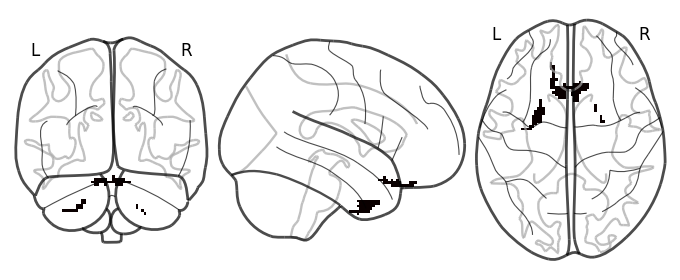

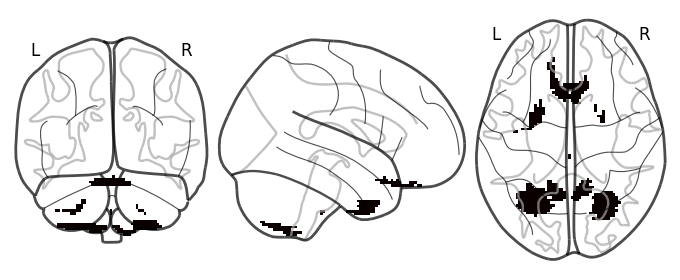

In [191]:
affine = nib.load('data/rest/sub-s03_ses-01_task-rest_run-1_space-MNI_desc-optcomDenoised_bold.nii.gz').affine
fnames = glob.glob('outputs/srm/missing*')
print([f[12:-4] for f in fnames])
files = [np.load(f).astype(float) for f in fnames]
print([np.sum(f) for f in files])
plot_glass_brain(nib.Nifti1Image(files[0], affine))
plot_glass_brain(nib.Nifti1Image(files[1], affine))

In [200]:
resample_target = nib.load('data/rest/sub-s03_ses-01_task-rest_run-1_space-MNI_desc-optcomDenoised_bold.nii.gz')

In [202]:
test = datasets.fetch_atlas_difumo(dimension=512, resolution_mm=2, data_dir='data/templates')

atlas_resampled = resample_img(test.maps, 
                                    target_shape = resample_target.shape[:3],
                                    target_affine = resample_target.affine,
                                    interpolation = 'nearest')

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\datasets\atlas.py:142: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


### Figuring out faulty connectome issue

In [55]:
from connectivity import get_parcellation, load_data_one_session, compute_fc_one_session
import glob
import numpy as np
import nibabel as nib
from math import tanh
from nilearn.maskers import NiftiLabelsMasker, MultiNiftiLabelsMasker
from nilearn.image import math_img
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome import ConnectivityMeasure
import pandas as pd

In [56]:
idx = np.array([3,6,7,9,10,11,12]) - 1 # affected sessions
files, confounds_files = (glob.glob('data/rest/*'), glob.glob('data/confounds/*'))
parcel_labels, parcel_map, parcel_mask = get_parcellation(atlas = 'schaefer', n_dimensions = 400, resample_target = nib.load(files[0])) 
gm_mask = math_img('img >= 0.5', img=nib.load('data/templates/tpl-MNI152NLin2009cAsym_res-02_label-GM_probseg.nii.gz'))
combined_mask = math_img('img1 * img2', img1=gm_mask, img2=parcel_mask)
parcel_masker = MultiNiftiLabelsMasker(
    mask_img = combined_mask,
    labels_img = parcel_map,
    labels = parcel_labels,
    standardize = 'zscore_sample',
    n_jobs=2
)
correlation_measure = ConnectivityMeasure(
    kind="correlation",
    vectorize = True # flatten 
)

In [58]:
parcel_data = parcel_masker.fit_transform(files, confounds = confounds_files)
connectomes = np.array(correlation_measure.fit_transform(parcel_data))
corrs = np.corrcoef(connectomes)

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

In [59]:
parcel_data2 = parcel_masker.fit_transform(files)
connectomes2 = np.array(correlation_measure.fit_transform(parcel_data2))
corrs2 = np.corrcoef(connectomes2)

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

In [145]:
confounds_include = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'framewise_displacement', 'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05', 'csf', 'white_matter']
confounds_files = glob.glob('data/confounds/*sub*')
new_confounds_files = [pd.read_csv(i, sep='\t')[confounds_include] for i in confounds_files]

parcel_data3 = parcel_masker.fit_transform(files, confounds=new_confounds_files)
connectomes3 = np.array(correlation_measure.fit_transform(parcel_data3))
corrs3 = np.corrcoef(connectomes3)

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

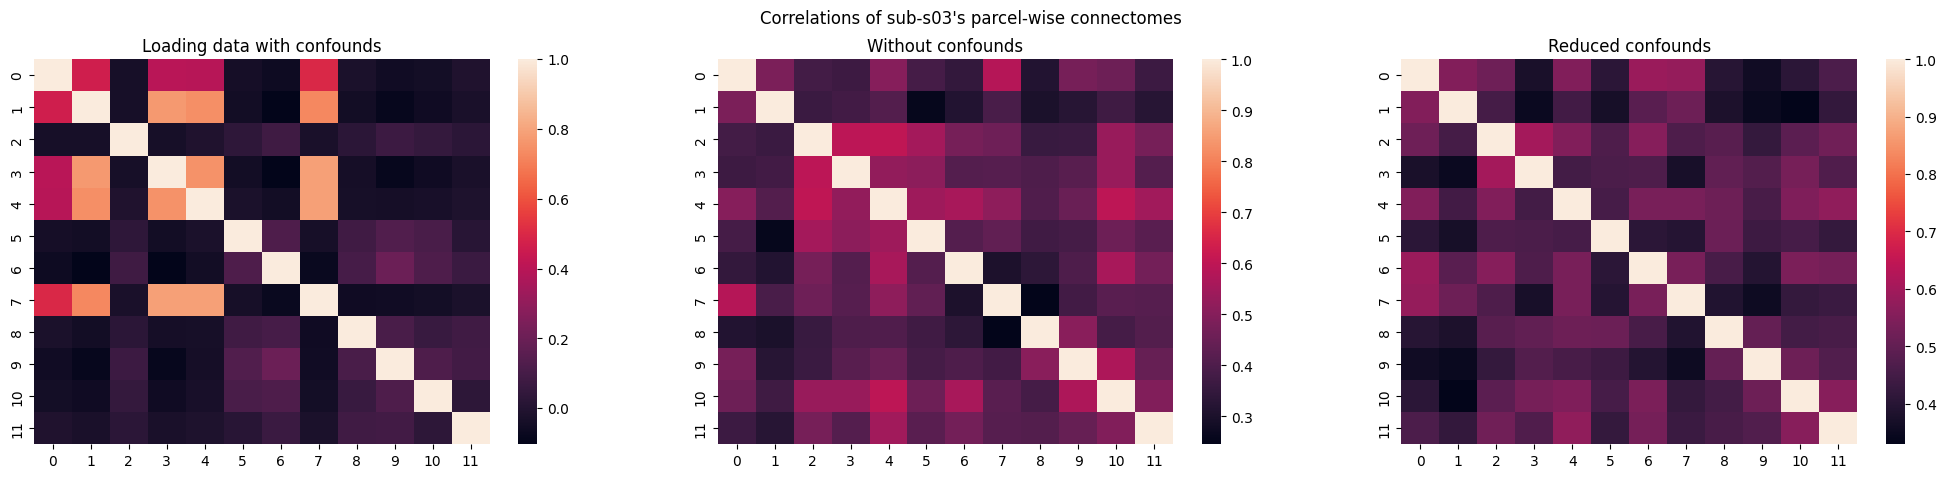

In [146]:
fig, ax = plt.subplots(1, 3, figsize=(25,5))
fig.suptitle('Correlations of sub-s03\'s parcel-wise connectomes')
ax[0].set_title('Loading data with confounds')
sns.heatmap(corrs, ax=ax[0])
ax[1].set_title('Without confounds')
sns.heatmap(corrs2, ax=ax[1])
ax[2].set_title('Reduced confounds')
sns.heatmap(corrs3, ax=ax[2])
plt.show()

In [150]:
test = pd.read_csv(confounds_files[0], sep='\t')
confounds_exclude = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'framewise_displacement', 
    'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05', 'csf', 'white_matter']

[i for i in test if i not in confounds_exclude]

['Unnamed: 0',
 'global_signal',
 'global_signal_derivative1',
 'global_signal_derivative1_power2',
 'global_signal_power2',
 'csf_derivative1',
 'csf_derivative1_power2',
 'csf_power2',
 'white_matter_derivative1',
 'white_matter_power2',
 'white_matter_derivative1_power2',
 'csf_wm',
 'tcompcor',
 'std_dvars',
 'dvars',
 'rmsd',
 't_comp_cor_00',
 'c_comp_cor_00',
 'c_comp_cor_01',
 'c_comp_cor_02',
 'c_comp_cor_03',
 'c_comp_cor_04',
 'c_comp_cor_05',
 'w_comp_cor_00',
 'w_comp_cor_01',
 'w_comp_cor_02',
 'w_comp_cor_03',
 'w_comp_cor_04',
 'w_comp_cor_05',
 'w_comp_cor_06',
 'w_comp_cor_07',
 'w_comp_cor_08',
 'w_comp_cor_09',
 'w_comp_cor_10',
 'w_comp_cor_11',
 'w_comp_cor_12',
 'w_comp_cor_13',
 'w_comp_cor_14',
 'w_comp_cor_15',
 'w_comp_cor_16',
 'w_comp_cor_17',
 'w_comp_cor_18',
 'w_comp_cor_19',
 'w_comp_cor_20',
 'w_comp_cor_21',
 'w_comp_cor_22',
 'w_comp_cor_23',
 'w_comp_cor_24',
 'w_comp_cor_25',
 'w_comp_cor_26',
 'w_comp_cor_27',
 'w_comp_cor_28',
 'w_comp_cor_29',
 

In [ ]:
def load_plot(confounds_include):
    confounds_include = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'framewise_displacement', 'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05', 'csf', 'white_matter']
    
    confounds_files = glob.glob('data/confounds/*sub*')
    new_confounds_files = [pd.read_csv(i, sep='\t')[confounds_include] for i in confounds_files]

    parcel_data = parcel_masker.fit_transform(files, confounds=new_confounds_files)
    connectomes = np.array(correlation_measure.fit_transform(parcel_data))
    corrs = np.corrcoef(connectomes)

    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    fig.suptitle(f'Confounds included: \'{confounds_include}\'')
    sns.heatmap(corrs, ax=ax)
    plt.show()

test_exclude = ['global','csf','trans','rot','white_matter','comp','non_steady','motion_outlier']
for k in range(len(test_exclude)):
    load_plot(test_exclude[k])


c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

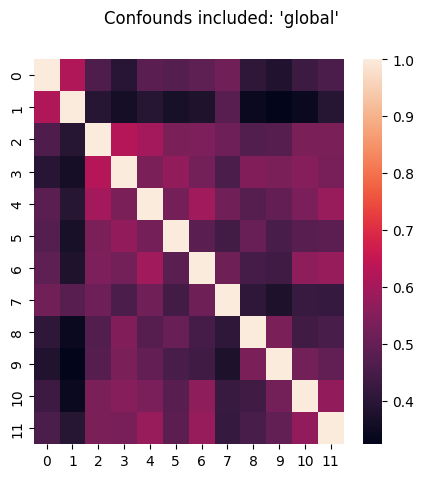

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

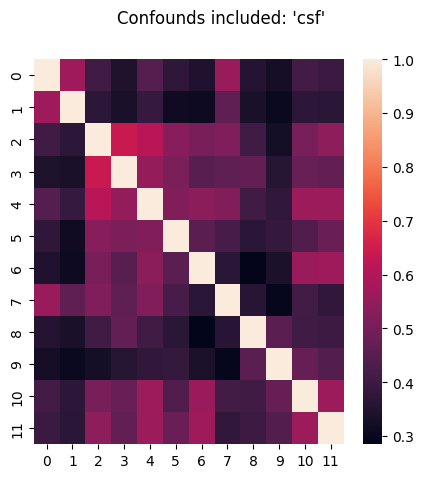

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

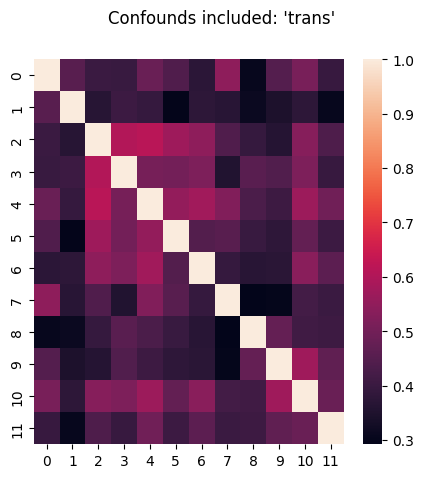

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

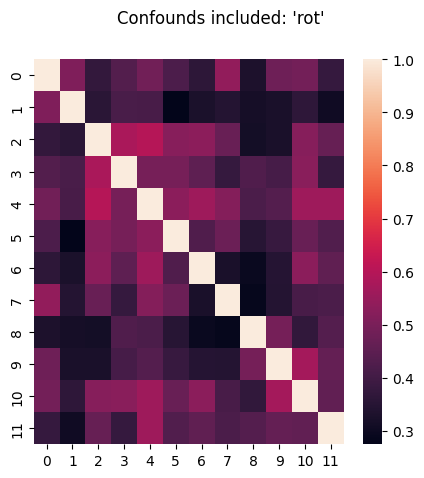

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

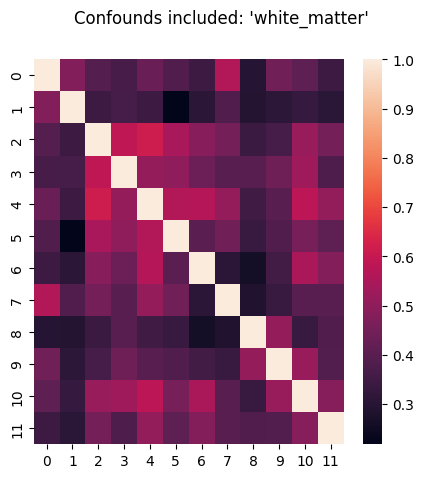

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

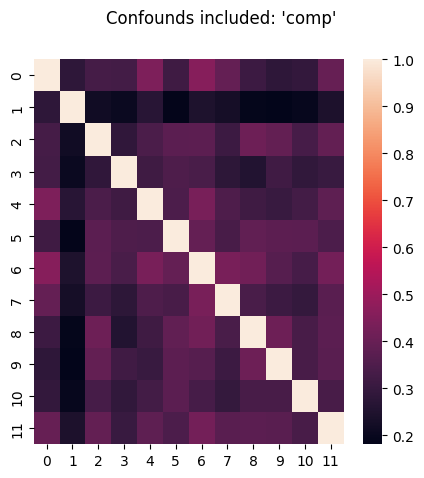

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

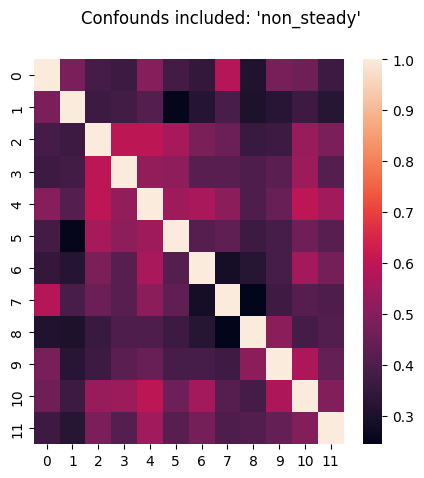

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

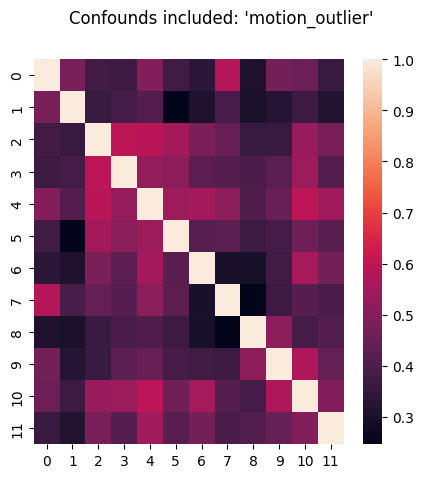

In [130]:
def load_plot(confounds_include):

    confounds_files = glob.glob('data/confounds/*sub*')
    new_confounds_files = []

    for i in range(len(confounds_files)):
        confounds = pd.read_csv(confounds_files[i], sep='\t')
        confounds[[j for j in confounds.columns if confounds_include in j]].to_csv(f'data/confounds/testing/{i}.tsv', sep='\t')
        new_confounds_files.append(f'data/confounds/testing/{i}.tsv')

    parcel_data = parcel_masker.fit_transform(files, confounds = new_confounds_files)
    connectomes = np.array(correlation_measure.fit_transform(parcel_data))
    corrs = np.corrcoef(connectomes)

    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    fig.suptitle(f'Confounds included: \'{confounds_include}\'')
    sns.heatmap(corrs, ax=ax)
    plt.show()

test_exclude = ['global','csf','trans','rot','white_matter','comp','non_steady','motion_outlier']
for k in range(len(test_exclude)):
    load_plot(test_exclude[k])


### Save SRM data on sherlock

In [ ]:
## Code 
from task_decoding import load_data, label_trs, srm_transform

tasks = ['goNogo','shapeMatching','spatialTS','cuedTS','flanker','nBack','stopSignal', 'directedForgetting']
for task in tasks:
    print(f'starting {task}')
    data, events, subjects = load_data(task)
    print(f'loaded data for {task}')

    # nas = na_check(data, subjects)
    # data, labels = average_trials(data, events)
    data, labels = label_trs(data, events)
    print(f'labeled {task}')

    data_srm = srm_transform(data, subjects)
    print(f'srm\'d  {task}')

    np.savez(f'/scratch/users/csiyer/decoding_outputs/srm_data_{task}.npz', *data_srm)
    np.savez(f'/scratch/users/csiyer/decoding_outputs/labels_{task}.npz', *labels)
    np.save(f'/scratch/users/csiyer/decoding_outputs/subjects_{task}.npz', subjects)

"""
Reading data back out:

load = np.load(f'/scratch/users/csiyer/decoding_outputs/srm_data_{task}.npz')
data_srm = [load[k] for k in load]
load = np.load(f'/scratch/users/csiyer/decoding_outputs/labels_{task}.npz')
labels = [load[k] for k in load]
subjects = np.load(f'/scratch/users/csiyer/decoding_outputs/subjects_{task}.npz')
"""

### Save task conditions to decode

In [89]:
# specify what we are decoding, use this to filter & label just these trials
task_conditions = {
    'goNogo': {
        'colname': 'correct_response',
        'values': {
            -1: 'no-go',
            71: 'go',
            89: 'go'
        }
    },
    'stopSignal': {
        'colname': 'trial_type',
        'values': {
            'go': 'go',
            'stop_failure': 'stop_failure',
            'stop_success': 'stop_success'
        }
    },
    'flanker': {
        'colname': 'trial_type',
        'values': {
            'congruent': 'congruent',
            'incongruent': 'incongruent'
        }
    },
    'cuedTS': {
        'colname': 'trial_type',
        'values' : {
            'tstay_cstay': 'tstay_cstay', 
            'tswitch_cswitch': 'tswitch_cswitch', 
            'tstay_cswitch': 'tstay_cswitch'
        }
    },
    'spatialTS': {
        'colname': 'trial_type',
        'values' : {
            'tstay_cstay': 'tstay_cstay', 
            'tswitch_cswitch': 'tswitch_cswitch', 
            'tstay_cswitch': 'tstay_cswitch'
        }
    },
    'nBack': {
        'colname': 'delay',
        'values': {
            1: '1-back',
            2: '2-back'
        }
    },
    'directedForgetting': {
        'colname': 'trial_type',
        'values': {
            'pos': 'pos',
            'neg': 'neg',
            'con': 'con'
        }
    },
    'shapeMatching': {
        'colname': 'trial_type',
        'values': { # PREVIOUSLY: decoded all 7 types. here, group into whether distractor is congruent with match/mismatch conclusion
            'SSS': 'congruent', # 'SSS',
            'DDD': 'congruent', # 'DDD'
            'DDS': 'incongruent', # 'DDS',
            'SDD': 'incongruent', # 'DDD',
            'DSD': 'incongruent', # 'DSD',
            'DNN': 'neutral', # 'DNN',
            'SNN': 'neutral' # 'SNN'
        }
    },
}

import json
with open('utils/task_decoding_conditions.json', 'w') as file:
    file.write(str(task_conditions))

### Visualize confusion matrix results

all trials


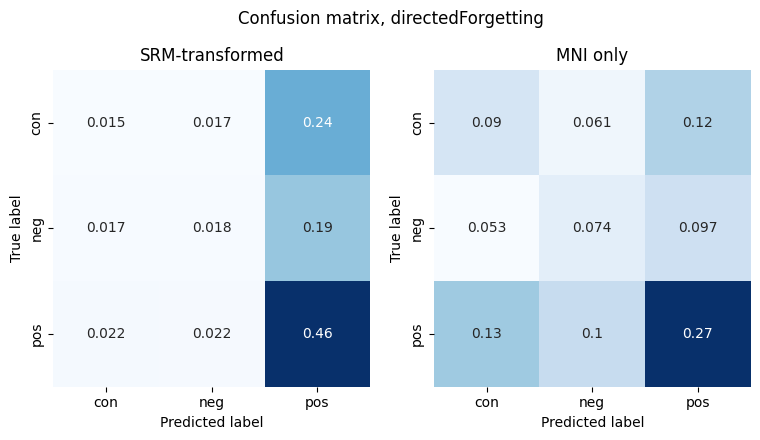

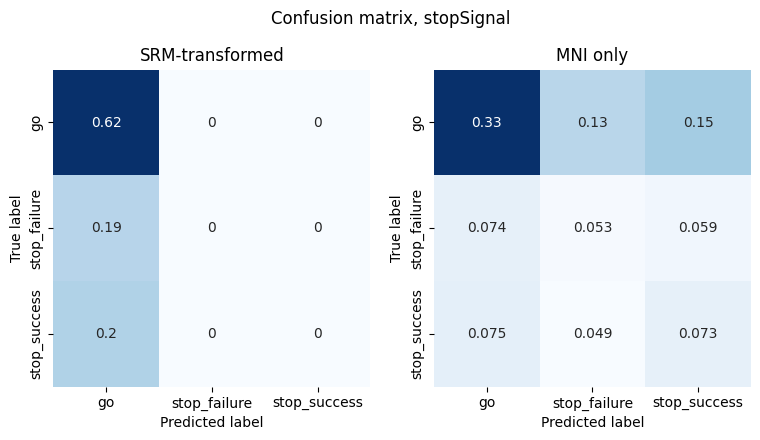

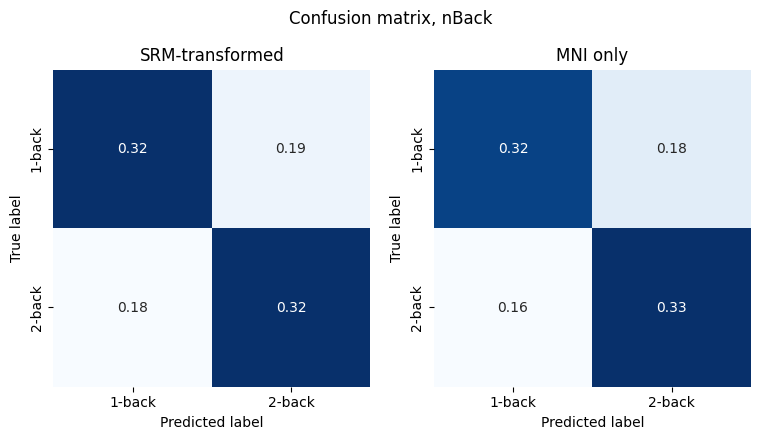

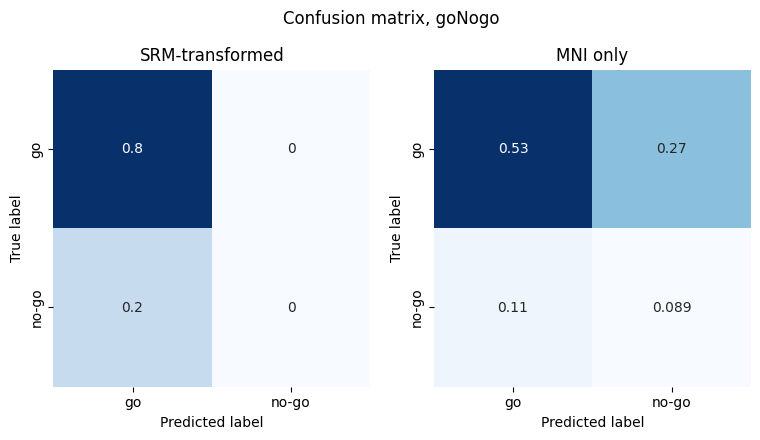

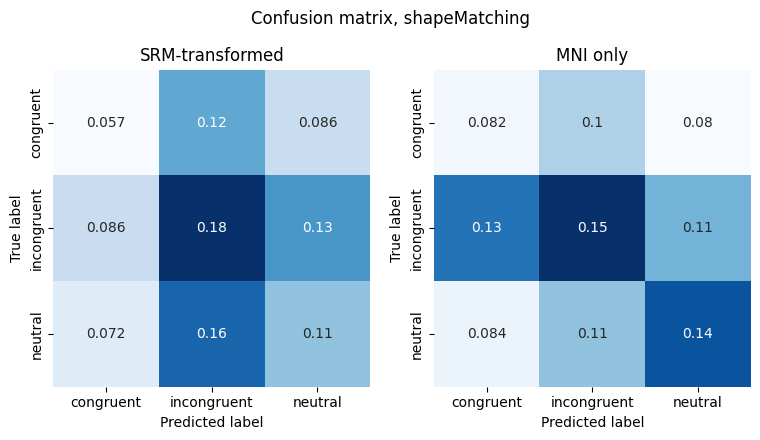

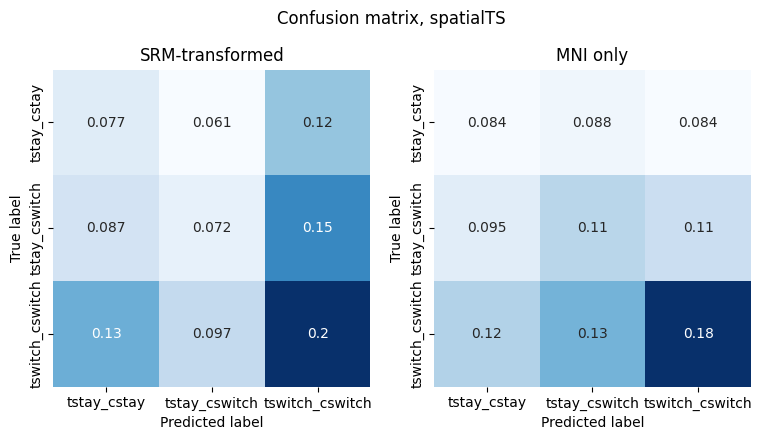

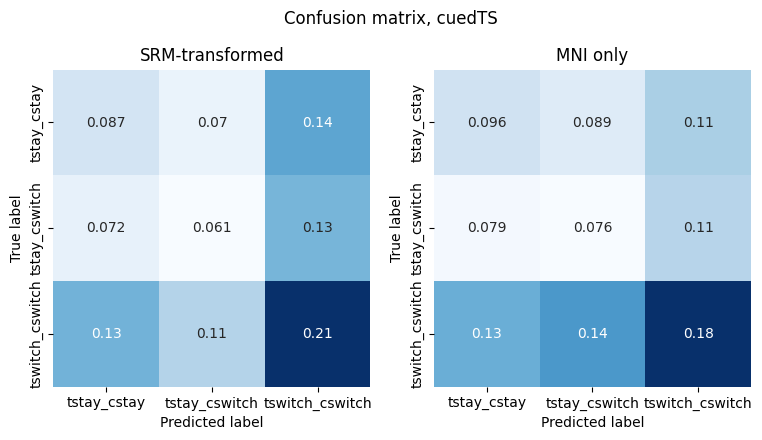

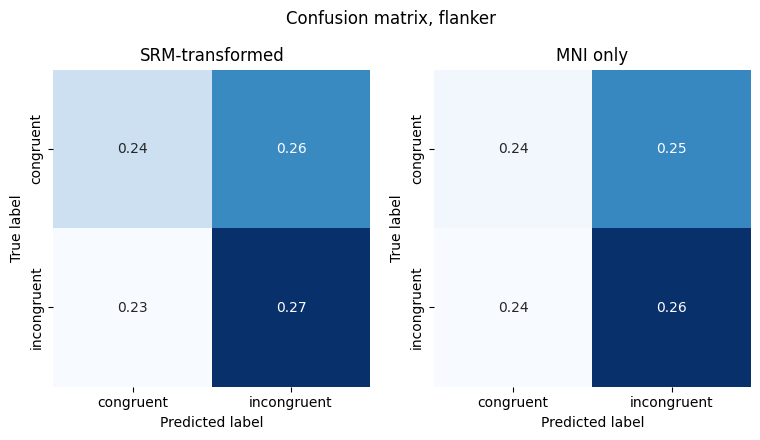

only correct trials


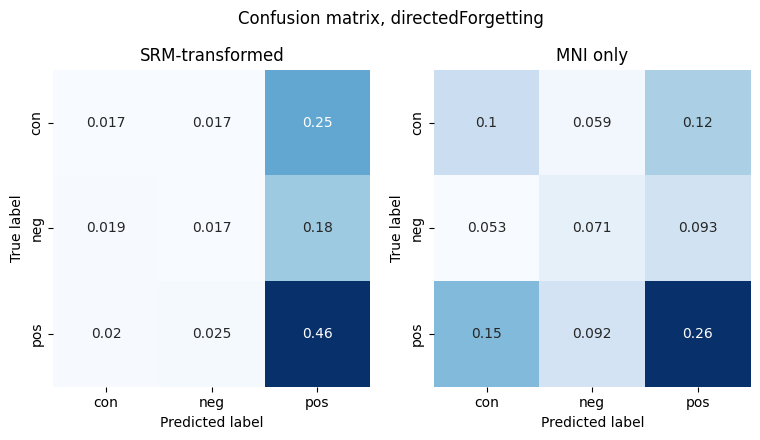

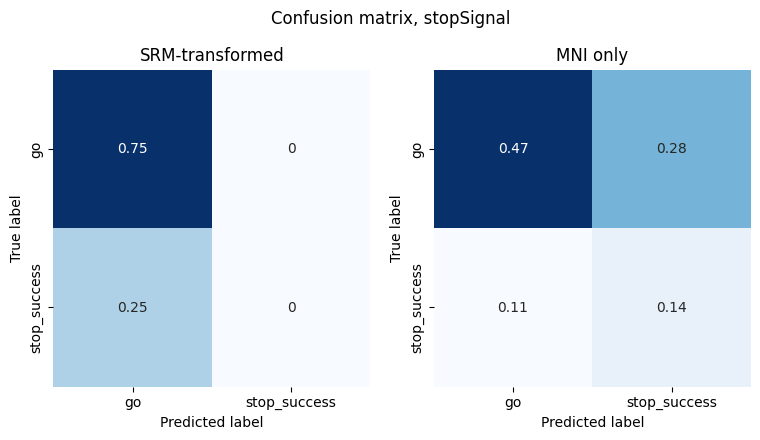

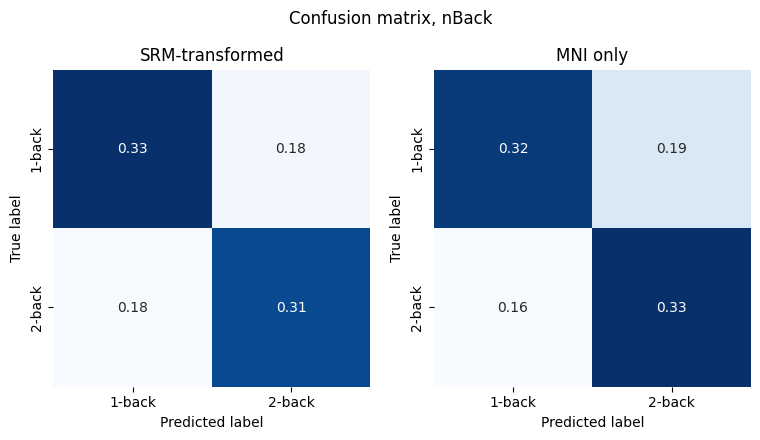

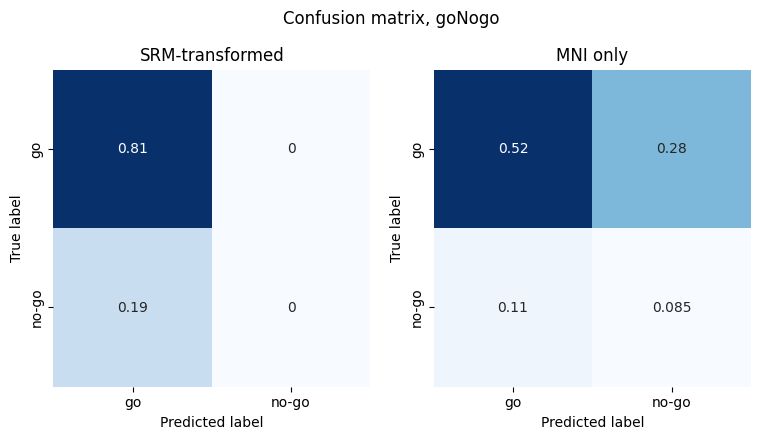

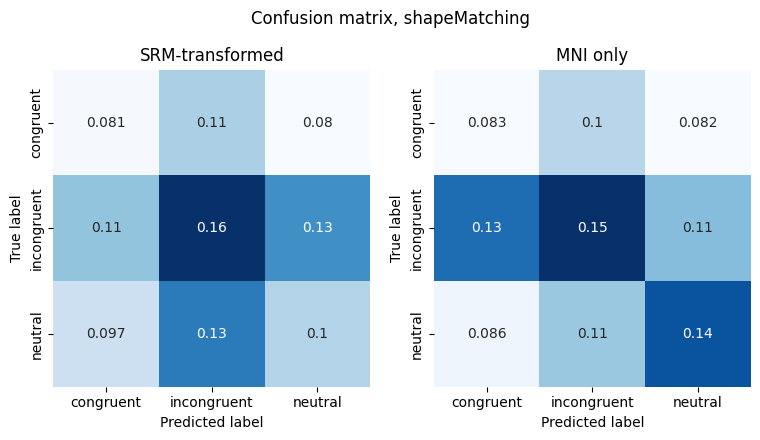

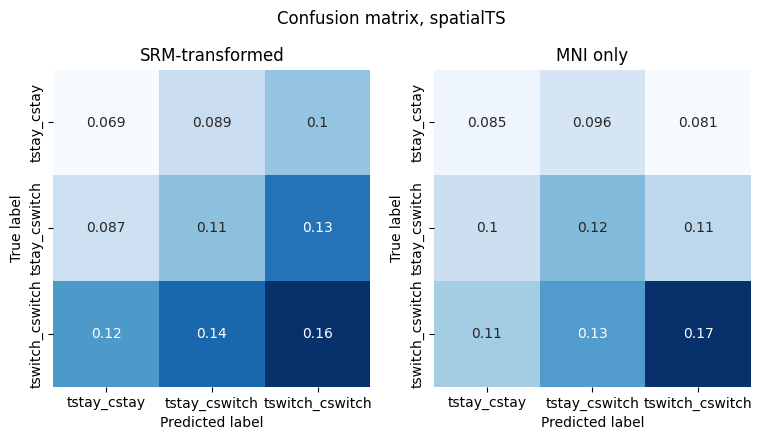

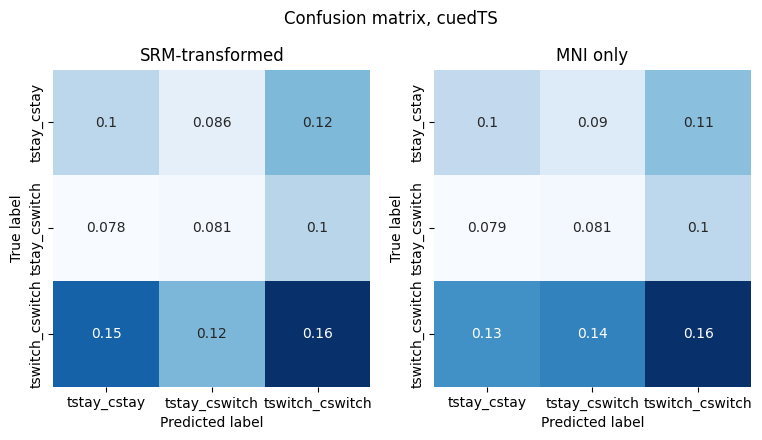

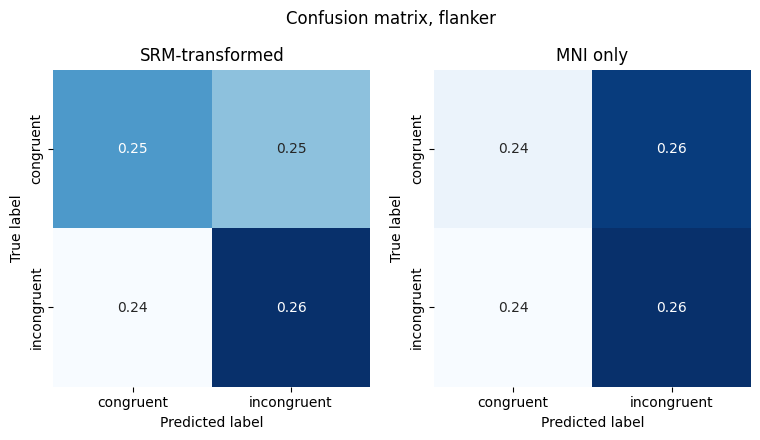

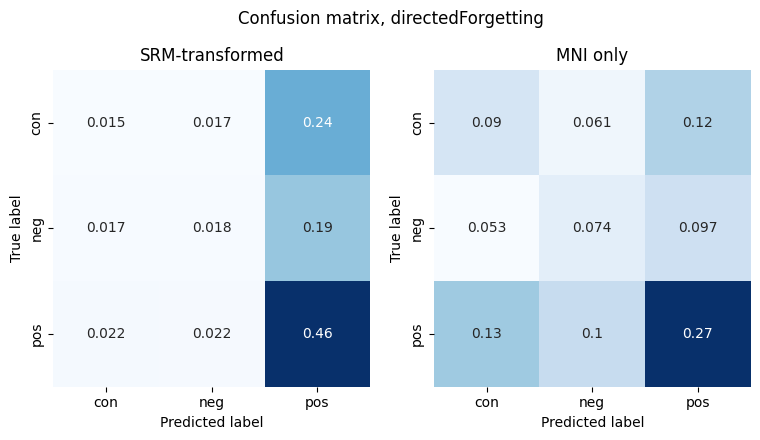

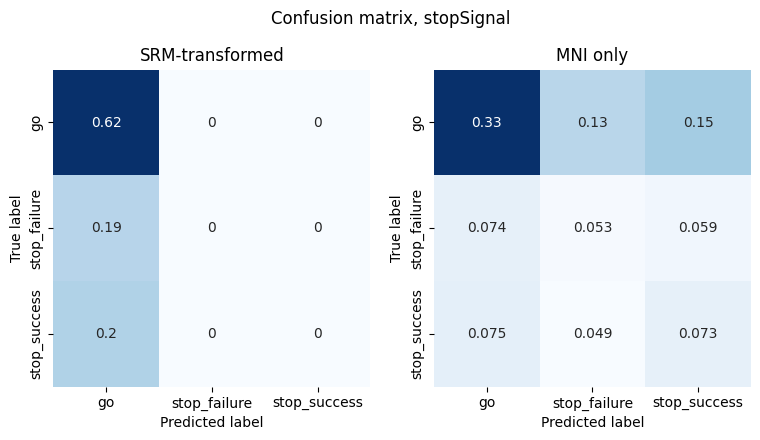

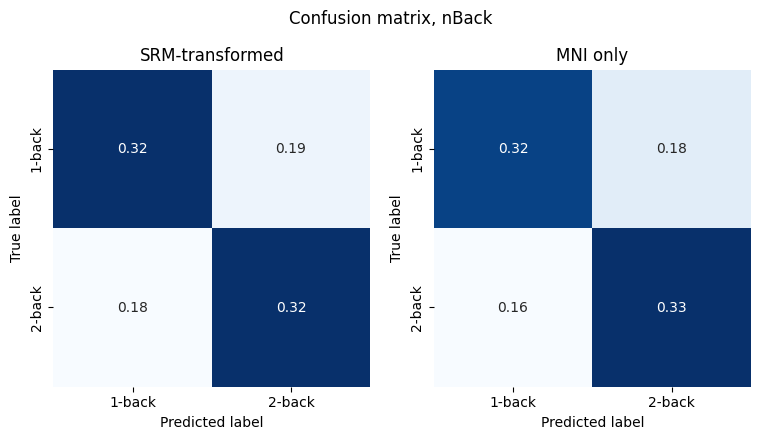

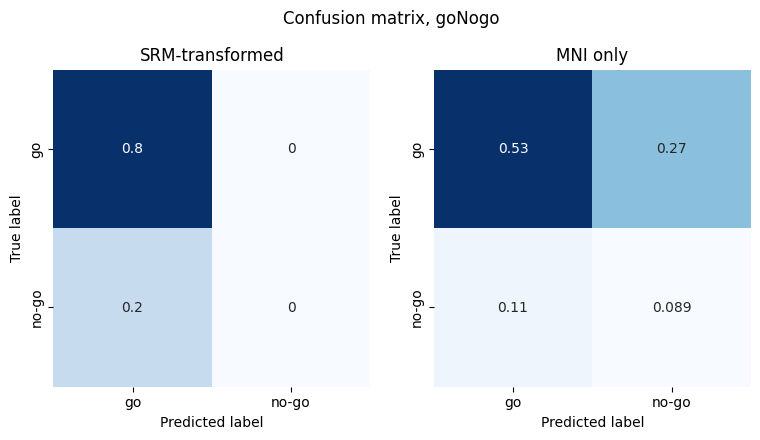

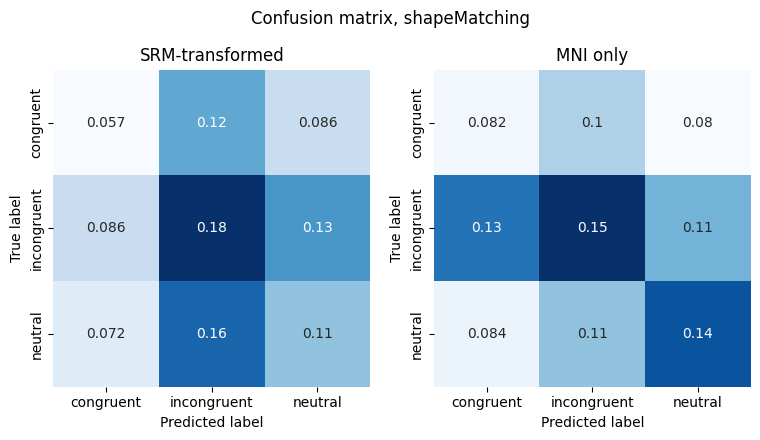

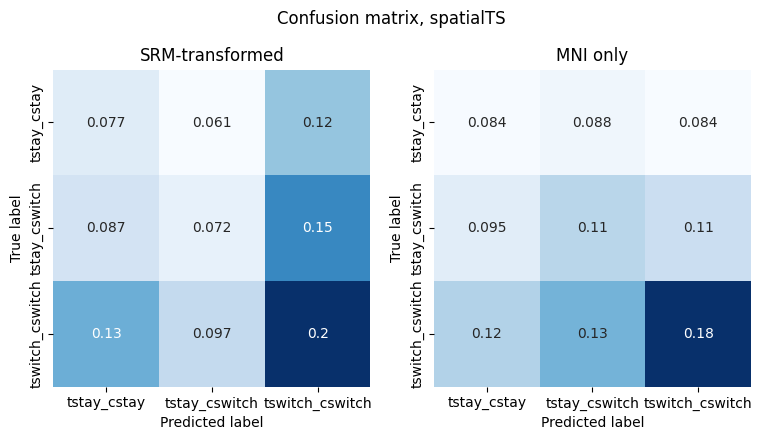

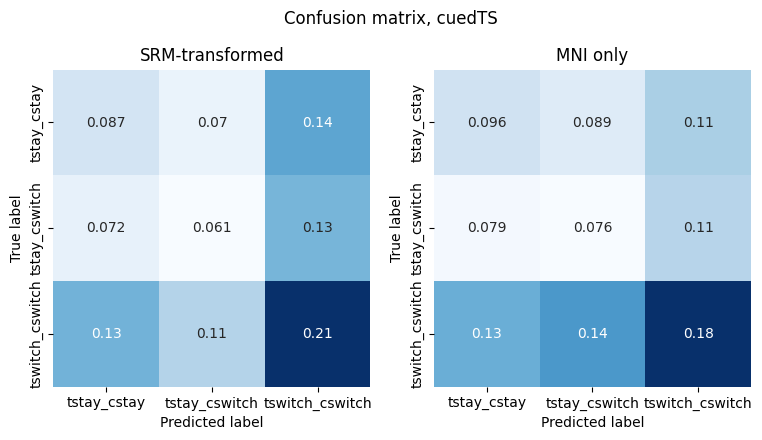

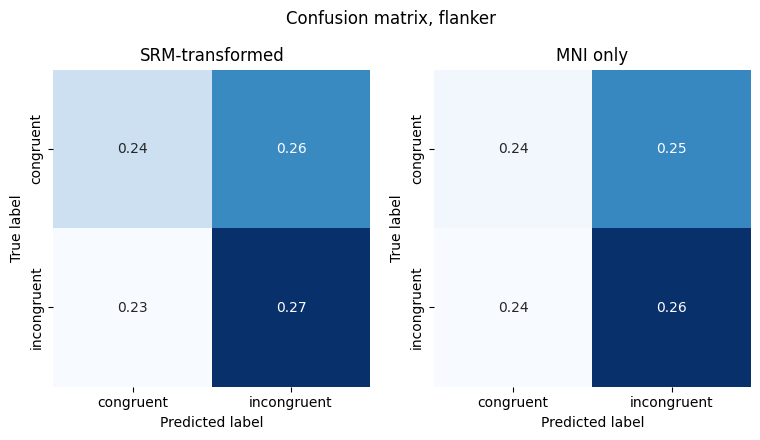

In [18]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

def aggregate_cms(task_cms):
    return np.sum(task_cms, axis=0) / np.sum(task_cms) 

def visualize_cms(fname, save = False, tasks = ['directedForgetting','stopSignal','nBack','goNogo','shapeMatching','spatialTS','cuedTS','flanker']):
    with open(fname, 'rb') as file:
        results = pickle.load(file)
    file.close()

    with open('utils/task_decoding_conditions.json', 'r') as file:
        task_conditions = eval(file.read())
    file.close()


    for i,task in enumerate(tasks):
        cm_srm = aggregate_cms(results['cms_srm'][i])
        cm_nosrm = aggregate_cms(results['cms_nosrm'][i])

        labels = sorted( np.unique([i for i in task_conditions[task]['values'].values()]) ) # sorted() should give same label order as the confusion_matrix fxn
        if task == 'stopSignal' and cm_srm.shape[0] < 3:
            # for correct-only, we have to exclude stop failure from the normal conditions
            labels = ['go', 'stop_success']

        fig, ax = plt.subplots(1,2, figsize=(9, 4.5))
        fig.suptitle(f'Confusion matrix, {task}')

        sns.heatmap(cm_srm, annot=True, cmap='Blues', cbar=False, square=True,
            xticklabels=labels, yticklabels=labels, ax=ax[0], label = 'SRM-transformed')
        ax[0].set_xlabel('Predicted label')
        ax[0].set_ylabel('True label')
        ax[0].set_title('SRM-transformed')
        sns.heatmap(cm_nosrm, annot=True, cmap='Blues', cbar=False, square=True,
            xticklabels=labels, yticklabels=labels, ax=ax[1], label = 'MNI only')
        ax[1].set_xlabel('Predicted label')
        ax[1].set_ylabel('True label')
        ax[1].set_title('MNI only')
    
        plt.show()

    if save:
        all_figures = plt.get_fignums()
        with PdfPages(fname[:-4] + '_plots.pdf') as pdf:
            for i, fig_num in enumerate(all_figures):
                plt.figure(fig_num)
                pdf.savefig()
                plt.close()

print('all trials')
visualize_cms('outputs/decoding/ALLTRIALS_results.pkl')#, save=True)
print('only correct trials')
visualize_cms('outputs/decoding/CORRECTONLY_results.pkl')#, save=True)


from matplotlib.backends.backend_pdf import PdfPages
def save_plots(filename='all_plots.png'):
    visualize_cms('outputs/decoding/ALLTRIALS_results.pkl')
    all_figures = plt.get_fignums()
    with PdfPages(filename) as pdf:
        for i, fig_num in enumerate(all_figures):
            plt.figure(fig_num)
            pdf.savefig()
            plt.close()

save_plots('outputs/decoding/all_plots.pdf')

# Testing

In [8]:
import glob
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import nibabel as nib
from nilearn.maskers import MultiNiftiMasker
import matplotlib.pyplot as plt

from connectivity import get_combined_mask
from task_decoding import label_trs, srm_transform, loso_cv
%autosave 5
%load_ext autoreload
%autoreload 2
# /oak/stanford/groups/russpold/data/network_grant/discovery_BIDS_21.0.1/derivatives/glm_data_MNI

def load_data_test():
    bids_dir = 'data/task/'
    # data_files = glob.glob(bids_dir + f'*optcomDenoised*nii.gz', recursive=True)
    data_files = glob.glob(bids_dir + f'*optcomDenoised*.nii.gz', recursive=True)
    event_files = ['data/task/event_files/sub-s03_ses-01_task-goNogo_run-1_events.tsv',
                   'data/task/event_files/sub-s10_ses-01_task-goNogo_run-1_events.tsv']

    data = MultiNiftiMasker(
        mask_img = get_combined_mask(local=True), # mask where it's gray matter above 50% and the parcellation applies
        standardize = 'zscore_sample',
        n_jobs = 1
    ).fit_transform(data_files) # , confounds = confound_files)
    events = [pd.read_csv(e, sep='\t') for e in event_files]
    subjects = [e[e.find('sub') : e.find('sub')+7] for e in event_files]
    return data, events, subjects

data, events, subjects = load_data_test()
# data, labels = label_trs(data, events)
# loso_cv(data, labels, subjects)

Autosaving every 5 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from task_decoding import load_data, srm_transform, label_trs, loso_cv
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
from joblib import Parallel, delayed
task = 'goNogo'
data, events, subjects = load_data(task)
data, labels = label_trs(data, events, task, correct_only=False) # CHANGE THIS TO FILTER ONLY CORRECT TRIALS
data_orig = data.copy()
data = srm_transform(data, subjects)

# aucs, cms = loso_cv(data_srm, labels, subjects)

In [ ]:
def concatenate_data_labels(idxs): # one giant matrix concatenating trials across subjects/sessions. this fxn is called in the one below.
    n_features = data[0].shape[1] # n_trials, n_voxels = data[0].shape 
    n_trials_total = sum([d.shape[0] for k,d in enumerate(data) if k in idxs]) # cant do data[0].shape[0] because some weird sessions have diff # trials
    train_data = np.zeros((n_trials_total, n_features)) # np.zeros((n_trials*(len(loso_indices)), n_voxels))
    train_labels = np.array([])
    start_index = 0 # initialize
    for idx in idxs:
        n_trials = data[idx].shape[0]
        end_index = start_index + n_trials
        train_data[start_index:end_index,:] = data[idx]
        train_labels = np.append(train_labels, labels[idx])
        start_index += n_trials
    return train_data, train_labels 

def traintest(i):
    sub = subjects[i]
    sub_indices = [j for j,s in enumerate(subjects) if s == sub]
    loso_indices = [j for j,s in enumerate(subjects) if s != sub]
    train_data, train_labels = concatenate_data_labels(loso_indices)
    test_data, test_labels = concatenate_data_labels(sub_indices)
    return train_data, train_labels, test_data, test_labels

def cm(i, c):
    train_data, train_labels, test_data, test_labels = traintest(i)
    classifier = LinearSVC(C = c, loss='hinge', dual = 'auto').fit(train_data, train_labels)
    print(confusion_matrix(test_labels, classifier.predict(test_data)))

